<a href="https://colab.research.google.com/github/collma/Sistemas-dinamicos-y-redes-neuronales/blob/main/Clase_3_Redes_Clasificacion%20%2B%20grafico%20cheto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow
#!pip install keras
#!pip install pydot
#!pip install graphviz

# Redes Neuronales

En este Notebook vamos a parender a crear y entrenar redes neuronales usando la librería **Keras**. En la primer sección vamos a resolver un problema de clasificación de imágenes y en la segunda sección un problema de regresión.

### Imports

Primero importemos las librerias que vamos a usar:

In [ ]:
# Imports de utilidades de Python
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

# Imports de Keras
from keras.datasets import mnist,fashion_mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils, plot_model
from keras.regularizers import l1

# let's keep our keras backend tensorflow quiet
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

### Preparando el dataset  -  Fashion MNIST
Vamos a trabajar usando un dataset de imágenes de prendas de ropa en baja resolución llamado fashion MNIST. Consiste en imagenes de 28x28 pixles en escala de grises de diez clases distintas de ropa. Para mas datos al respecto, peueden consultar la [documentacion de keras](https://keras.io/api/datasets/fashion_mnist/).

Primero importamos el dataset:

In [ ]:
(X_train_raw, y_train), (X_test_raw, y_test) = fashion_mnist.load_data()

categories = ['T-shirt/top', 'Trouser','Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Exploremos el tamaño del dataset. Noten que las imágenes poseen una resolución de 28 x 28 píxeles.

In [ ]:
# let's print the shape before we reshape and normalize
print("X_train shape:", X_train_raw.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test_raw.shape)
print("y_test shape:", y_test.shape)

X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


Veamos como se ven algunas de las imágenes y que etiquetas les corresponden.

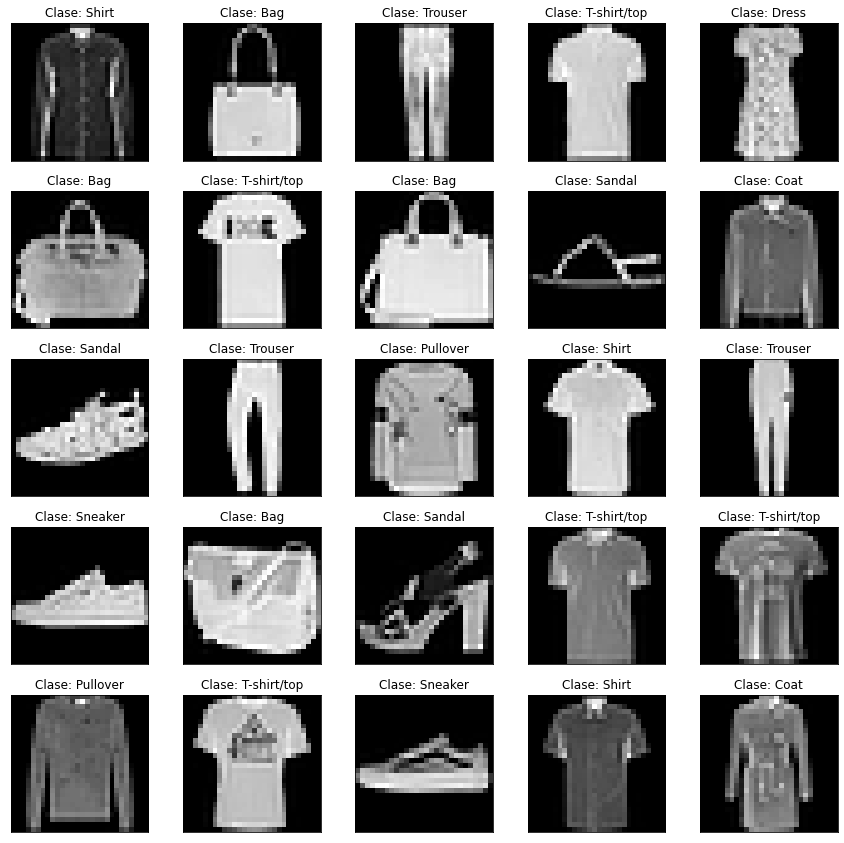

In [ ]:
fig = plt.figure(figsize = (12,12))
j = np.random.randint(0, len(X_train_raw))
for i in range(25):
    j = np.random.randint(0, len(X_train_raw))
    plt.subplot(5,5,i+1)
    plt.tight_layout()
    plt.imshow(X_train_raw[j], cmap='gray', interpolation='none')
    plt.title("Clase: {}".format(categories[y_train[j]]))
    plt.xticks([])
    plt.yticks([])
plt.show()

¿Cómo es la distribución de valores en la imagen?

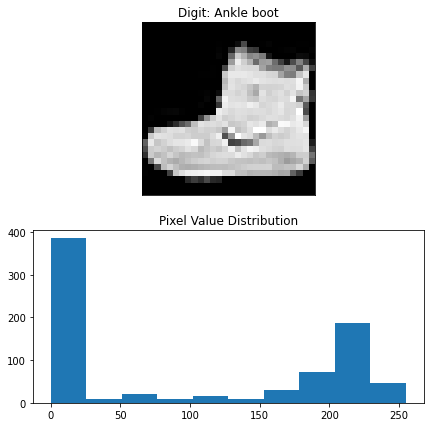

In [ ]:
fig = plt.figure(figsize = (7,7))
plt.subplot(2,1,1)
plt.imshow(X_train_raw[0], cmap='gray', interpolation='none')
plt.title("Digit: {}".format(categories[y_train[0]]))
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.hist(X_train_raw[0].reshape(784))
plt.title("Pixel Value Distribution")
plt.show()

Preparamos los datos para entrar al modelo.

In [ ]:
# building the input vector from the 28x28 pixels
X_train_raw = X_train_raw.reshape(60000, 784)
X_test_raw = X_test_raw.reshape(10000, 784)
X_train_raw = X_train_raw.astype('float32')
X_test_raw = X_test_raw.astype('float32')

# normalizing the data to help with the training
X_train = X_train_raw/255.0
X_test = X_test_raw/255.0

# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

Train matrix shape (60000, 784)
Test matrix shape (10000, 784)


Veamos la variable ```y```, cuales son los valores posibles que puede tomar cuantas veces toma cada uno.



In [ ]:
values,counts = np.unique(y_train, return_counts=True)
print("Values:", values)
print("Counts:", counts)

Values: [0 1 2 3 4 5 6 7 8 9]
Counts: [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]


Para entrenar la red neuronal, vamos convertir la variable `y` que consiste en un vector de largo 60000 que puede tomar 10 valores distintos a una nueva variabvle `Y` la cual consiste en una matriz de 60000x10 donde cada columna tiene un 1 (o un 0) que indica la pertenencia (o no) a cada una de las clases. A este proceso se lo llama one-hot-encoding.

In [ ]:
# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape of y_train [before one-hot encoding]: ", y_train.shape)

# Generamos las nuevas variables que vamos a usar como etiquetas obejtivo
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape of Y_train [after one-hot encoding]: ", Y_train.shape)

Shape of y_train [before one-hot encoding]:  (60000,)
Shape of Y_train [after one-hot encoding]:  (60000, 10)


### Red Nueronal Simple
Para empezar, vamos a armar una red de una única capa (layer). Esto sería equivalente a tener un 10 percetrones con 784 inputs y un único output.  Cada perceptron está encargado de clasificar si la imagen pertenece o no a esa clase en particular. Verán que con keras esto es muy muy sencillo.

Primero, se define un objeto que es el modelo. A este objeto le iremos agregando layers que definiran cual es la arquitectura de la red (numero de unidades y numeros de capas). 

En esta instancia tambien vamos a definir el tipo de activación y el valor de regularización que vamos a utilizar.

In [ ]:
# Definimos el modelo secuencial (primero esta vacio)
model_simple = Sequential()

# Agregamos una capa, con activación softmnax
model_simple.add(Dense(10,activation='softmax'))

# Para analizar luego - comentar la anterior y descomentar esta linea
# model_simple.add(Dense(10, kernel_regularizer = l1(0.0005),activation='softmax'))


Luego se compila el modelo. En este paso se determina cual será la función de costo, con que métricas vamos a monitorear el proceso y cual será el optimizador (generalmente, algún tipo de descenso por gradiente).

Este problema de clasificación que estamos resolviendo es un una problema multi-clase donde las clases son mutuamente excluyentes (solo se peude pertenecer a una de las clases). En este tipo de problemas se debe usar en la ultima capa de la red el tipo de activación `softmax`, y se suele elegir la `categorical_crossentropy` como función de costo a optimizar.

In [ ]:
model_simple.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')

Con todo esto definido, podemos entrenar la red.

In [ ]:
history = model_simple.fit(X_train, Y_train,
          batch_size=32, epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5990 - categorical_accuracy: 0.7984 - val_loss: 0.5107 - val_categorical_accuracy: 0.8193
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4622 - categorical_accuracy: 0.8412 - val_loss: 0.4767 - val_categorical_accuracy: 0.8336
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4367 - categorical_accuracy: 0.8493 - val_loss: 0.4736 - val_categorical_accuracy: 0.8351
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4220 - categorical_accuracy: 0.8540 - val_loss: 0.4566 - val_categorical_accuracy: 0.8404
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4130 - categorical_accuracy: 0.8581 - val_loss: 0.4521 - val_categorical_accuracy: 0.8410
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4077 - categorical_accuracy: 0.8573 - val_loss: 0.4667 - val_categorical_accuracy:

El modelo ya está entrenado! Ahora veamos que forma tien la salida del modelo. Para esto vamos a "pasar" la primer instancia del test set por el modelo y ver como es la salida:

In [ ]:
salida = model_simple.predict(X_test[0:1])

print('Shape de la salida:',salida.shape)
print('Salida:',salida)


Shape de la salida: (1, 10)
Salida: [[4.6457561e-07 3.5937077e-08 1.1563243e-05 2.3545915e-06 4.8575639e-06
  8.4128439e-02 2.4395440e-05 5.4915290e-02 5.2455389e-03 8.5566705e-01]]


Lo que tenemos a la salida es la probabilidad de pertenecia a cada una de las clases. Tomaremos que la clase asignada por la red es aquella con mayor valor. En este caso:

In [ ]:
ertiqueta_prediccion = salida[0].argmax()
etiquta_real = y_test[0]

print('Calse asignada por la red:', ertiqueta_prediccion)
print('Calse real:', etiquta_real)

Calse asignada por la red: 9
Calse real: 9


Para evaluar de manera generaal el resultado total vamos a calcular el accuracy sobre todo el set de entrenamiento y el todo el set de testeo:

In [ ]:
# Usamos el modelo para predecir sobre todas las instancias en ambos sets
y_train_pred = model_simple.predict(X_train)
y_test_pred = model_simple.predict(X_test)

# Tomamos como clase predicha aquella con mayor probabilidad
train_accuracy =  metrics.accuracy_score(y_train_pred.argmax(axis=1),y_train)
test_accuracy =  metrics.accuracy_score(y_test_pred.argmax(axis=1), y_test)

print('Accuracy en el train set:', train_accuracy)
print('Accuracy en el test set:', test_accuracy)

Accuracy en el train set: 0.8681333333333333
Accuracy en el test set: 0.8461


Para inspeccionar un poco mejor los resultados, vamos a utilizar una función llamada `classification_report` (que computa distintas métricas sobre los datos) y vamos a calcular tambien la matrix de confusión. La clase que viene hablaremos de distitnas Métricas para evaluar un resultado.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print ("Classification Report")
print(classification_report(y_test, y_test_pred.argmax(axis=1)))
print ("Confusion Report")
print(confusion_matrix(y_test, y_test_pred.argmax(axis=1)))

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.77      0.81      1000
           1       0.98      0.96      0.97      1000
           2       0.72      0.74      0.73      1000
           3       0.81      0.89      0.85      1000
           4       0.73      0.74      0.74      1000
           5       0.96      0.93      0.94      1000
           6       0.64      0.58      0.61      1000
           7       0.91      0.95      0.93      1000
           8       0.92      0.96      0.94      1000
           9       0.96      0.94      0.95      1000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Confusion Report
[[774   2  13  66   6   0 120   0  19   0]
 [  3 957   3  28   5   0   2   0   2   0]
 [ 18   6 745  12 130   1  75   0  13   0]
 [ 14   9  12 889  32   0  36   0   8   0]
 [  0   1 122  42 744   0  82 

#### ¿Qué está mirando la red?

Al tener una red simple de una sola capa, podemos evaluar con presición cuales son las carácterísticas de las imagenes que la red está pesando para decidir si una imagen corresponde a o no a determinada clase. Esta información esta codificada en el peso que la red le asigna a cada pixel.

Podemos indagar el valor aprendido por la red apra los pesos mediante el metodo `get_weights()`:

In [ ]:
weigths = model_simple.get_weights()[0]
print(weigths.shape)

(784, 10)


Cada una de las 10 neuronas (uno por cada clase) tiene 784 pesos, uno por cada pixel de la imagen (sin contar los bias). La lectura del vector numérico de pesos no será muy informativa. Pero veamos que pasa si los llevamos a la forma `(28,28)` y los graficamos como una imagen.


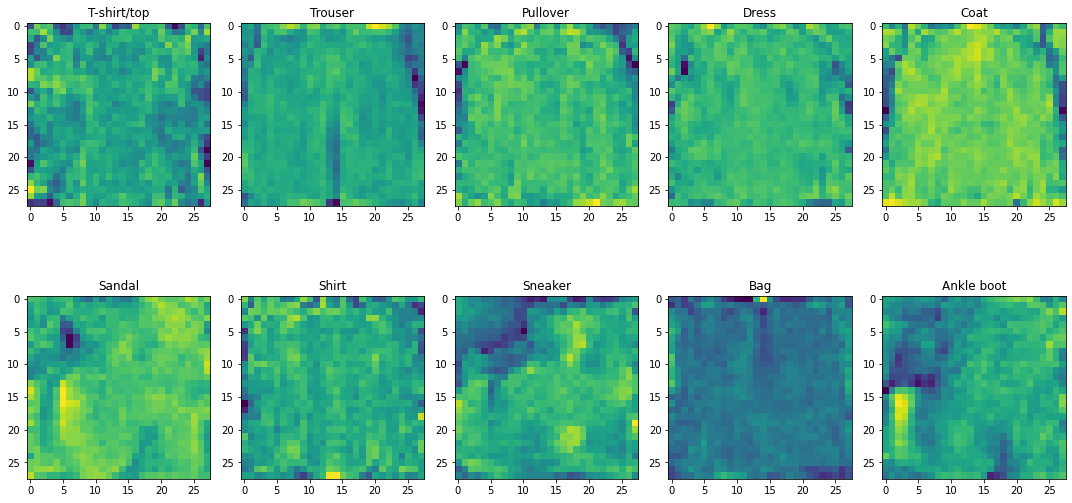

In [ ]:
plt.figure(figsize = (15,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    w0 = weigths[:,i]
    plt.title(categories[i])
    plt.imshow(w0.reshape(28,28))
plt.tight_layout()
plt.show()

La escala de colores nos indica la contribución positiva o negativa de cada uno de los pixeles para la desición de la neurona. Noten que aparecen sombras de las formas mas comunes apra cada tipo de producto. Tal vez el ejemplo mas evidente sea en la categoría de Pantalones, donde la neurona esta evaluando que no haya píxeles blancos entre las piernas.

**Ejercicios:** 
*   Vayan nuevamente a la celda donde definimos el modelo, y cambien la linea `model_simple.add()` que usamos por la que está comentada y vuelvan a correr todas las celdas. En este segundo caso, agregamos un tipo de regularización llamdo `l1` a los pesos del modelo (ya discutiremos esto en detalle mas adelante). 
*   Comparen el valor obtenido de acuraccy en el train y test set en ambos casos, y miren las matrices de los pesos. ¿Qué observación pueden hacer al respecto?
*   Observen la matriz de confusión y determine cuales fueron las clases mas dificiles de separar (las que el algoritmo mas se confunde). ¿Les parece razonable esto?






### Red Neuronal Profunda

Vamos resolver el mismo problema de clasificación, pero ahora con una red neuronal de varias layers.

Noten que las capas se puede agregar consecutivamente una atras de la otra. La cantidad de neuroans y capas que agreguemos es lo que va a determinar la arquitectura de nuestra red. Esto puede variar según el problema a resolver, pero lo importante es que la capa de entrada y la de salida tengan forma adecuada, es decir, que coincida con la de los datos de entremaniento. En nuestro caso, la capa entrada debe tener dimensión 784 y la salida uno de 10.

In [ ]:
# building a linear stack of layers with the sequential model
model = Sequential()
model.add(Dense(512, input_shape=(784,)))                        
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

Nuevamente, una vez que defuinimos el modelo, debemos compilarlo.

In [ ]:
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')

Para visualizar las características de nuestro modelo, podemos usar el método `.summary()`. Este nos muestra cual es la secuencia de capas que componen a nuestro modelo y la cantidad de unidades y parámetros que tiene cada una.

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)              

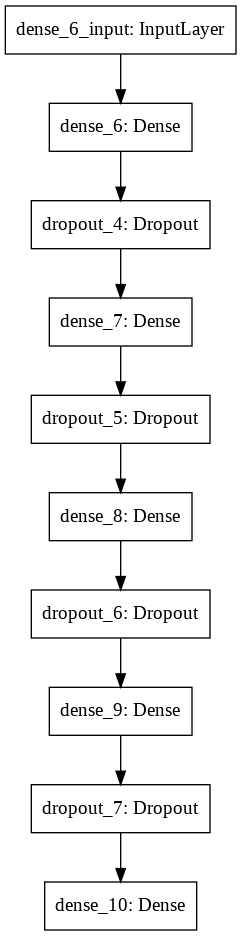

In [ ]:
plot_model(model)

Y ahora si, finalmente lo entrenamos con los datos.

In [ ]:
# training the model and saving metrics in history
history = model.fit(X_train, Y_train,
          batch_size=32, epochs=10,
          verbose=1,
          validation_data=(X_test, Y_test))

Epoch 1/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.6225 - categorical_accuracy: 0.7765 - val_loss: 0.4887 - val_categorical_accuracy: 0.8188
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.4829 - categorical_accuracy: 0.8276 - val_loss: 0.4493 - val_categorical_accuracy: 0.8384
Epoch 3/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.4480 - categorical_accuracy: 0.8387 - val_loss: 0.4248 - val_categorical_accuracy: 0.8508
Epoch 4/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.4267 - categorical_accuracy: 0.8475 - val_loss: 0.4343 - val_categorical_accuracy: 0.8407
Epoch 5/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.4132 - categorical_accuracy: 0.8554 - val_loss: 0.4100 - val_categorical_accuracy: 0.8549
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.4051 - categorical_accuracy: 0.8576 - val_loss: 0.3923 - val_categorical_acc

Este gráfico que vamos a hacer se llama curva de aprendizaje y es la manera clásica de graficar el proceso de entrenamiento en la red. Se trata del valor de alguna métrica (en nuestro caso la `accuracy`) y de la función de costo  (en nuestro caso la `categorical_crossentropy`) en función del número de epochs de entrenamiento.

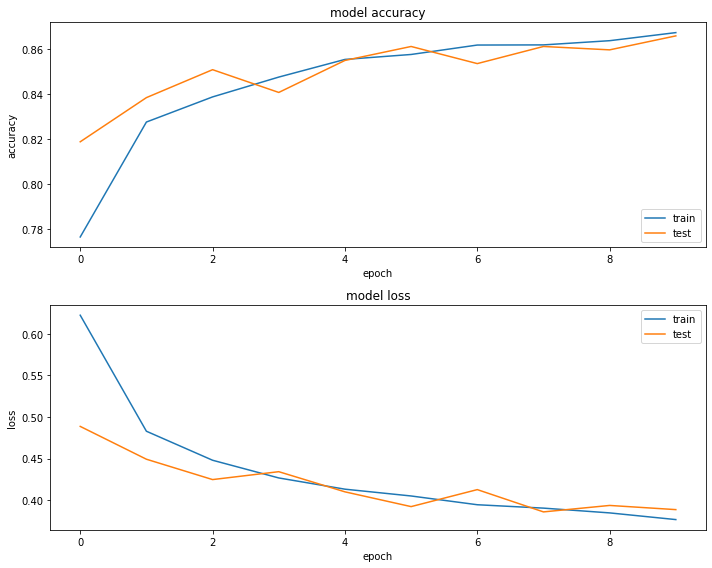

In [ ]:
# plotting the metrics
fig = plt.figure(figsize = (10,8))
plt.subplot(2,1,1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

Nuevamente podemos calcular de manera manual el accuraccy en el train y test set y armar el reporte de clasificación.

In [ ]:
# Usamos el modelo para predecir sobre todas las instancias en ambos sets
y_train_pred_NN = model.predict(X_train)
y_test_pred_NN = model.predict(X_test)

# Tomamos como clase predicha aquella con mayor probabilidad
train_accuracy =  metrics.accuracy_score(y_train_pred_NN.argmax(axis=1),y_train)
test_accuracy =  metrics.accuracy_score(y_test_pred_NN.argmax(axis=1), y_test)

print('Accuracy en el train set:', train_accuracy)
print('Accuracy en el test set:', test_accuracy)

Accuracy en el train set: 0.88545
Accuracy en el test set: 0.8658


Classification Report
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1000
           1       0.97      0.97      0.97      1000
           2       0.71      0.87      0.78      1000
           3       0.82      0.91      0.86      1000
           4       0.81      0.73      0.77      1000
           5       0.98      0.95      0.96      1000
           6       0.75      0.55      0.63      1000
           7       0.89      0.98      0.93      1000
           8       0.96      0.98      0.97      1000
           9       0.98      0.91      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.86     10000
weighted avg       0.87      0.87      0.86     10000

Confusion Report
[[814   7  18  62   4   0  85   1   9   0]
 [  0 969   1  21   6   0   1   0   2   0]
 [ 11   2 869  15  63   0  36   0   4   0]
 [ 19  16  10 908  22   1  22   0   2   0]
 [  0   0 180  51 732   1  35 

Text(0.5, 0, 'Predicted Label')

<Figure size 432x288 with 0 Axes>

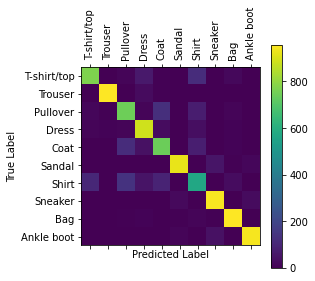

In [ ]:
print ("Classification Report")
print(classification_report(y_test, y_test_pred_NN.argmax(axis=1)))
print ("Confusion Report")
print(confusion_matrix(y_test, y_test_pred_NN.argmax(axis=1)))

# Matiz de confusion, escala de colores
cm = confusion_matrix(y_test, y_test_pred.argmax(axis=1))
xticks = np.arange(10)
fig = plt.figure()
plt.matshow(cm)
plt.colorbar()
plt.xticks(xticks, categories, rotation = 'vertical')
plt.yticks(xticks, categories, rotation = 'horizontal')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')


**Ejercicios:** 
*   Vayan nuevamente a la celda donde definimos el modelo, descomenten las lineas que dicen `model.add(Dropout(0.2))` y vuelvan a correr todas las celdas. En este segundo caso, agregamos una estrategia de regularización llamda dropout (ya discutiremos esto en detalle mas adelante). 
*   Comparen el valor obtenido de acuraccy y loss en el train y test set en ambos casos ¿Qué observación pueden hacer al respecto?
*   Prueben distintas arquitecturas de red.